<div class="alert alert-success h1" role="alert">
    <b>Vueling Tech Hack</b>
</div>

por [Guillermo Seoane](https://www.linkedin.com/in/guilleseoane/)

In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, LabelBinarizer, OrdinalEncoder
from sklearn.preprocessing import Binarizer
import sklearn.preprocessing as preprocessing

from sklearn import set_config

from sklearn.model_selection import train_test_split

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns

import json

import warnings
warnings.filterwarnings("ignore")


Download 'Mapping Destination Countries':

In [2]:
country_map = {"China": 0, "India": 1, "Russian Federation": 2, "United Arab Emirates": 3, "Austria": 4, "Germany": 5, "Greece": 6, "Italy": 7, "Turkey": 8, "Belgium": 9, "Egypt": 10, "France": 11, "Morocco": 12, "Spain": 13, "Switzerland": 14, "United Kingdom": 15, "South Africa": 16, "United States": 17, "Canada": 18, "Czech Republic": 19, "Ukraine": 20, "Netherlands": 21, "Thailand": 22, "Denmark": 23, "Qatar": 24}

Cargamos los datos

In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

Obtenemos informacion basica del tipo de datos que contiene el dataset con la funcion *info()*.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276982 entries, 0 to 276981
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Date                   276982 non-null  object
 1   Origin Country         276982 non-null  object
 2   Origin Continent       276982 non-null  object
 3   Destination Country    276982 non-null  int64 
 4   Destination Continent  276982 non-null  object
 5   Total flights          276982 non-null  object
 6   Total seats            276982 non-null  object
 7   Total ASKs             276982 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.9+ MB


Información disponible en el dataset:

* **Date:** Flight date.
* **Origin_Country:** Country of origin.
* **Origin_Continent:** Continent of origin.
* **Destination_Country:** Country of destination.
* **Destination_Continent:** Destination continent.
* **Total_flights:** Total number of flights.
* **Total_seats:** Total number of seats.
* **Total_ASKs (Available Seat Kilometer):**. Total seat numbers available by the total number of km these seats have flown.  

Utilizamos la función *head()* para visualizar las primeras filas de datos de la estructura del dataset

In [5]:
df_train.head(5)

,Date,Origin Country,Origin Continent,Destination Country,Destination Continent,Total flights,Total seats,Total ASKs
0,Jul 2009,United Kingdom,Europe,13,Europe,"9,032","1,531,683","2,447,559,137"
1,Apr 2008,Lebanon,Middle East,9,Europe,5,760,"2,389,940"
2,Apr 2005,Switzerland,Europe,11,Europe,"1,471","158,661","66,533,450"
3,Aug 2016,Israel,Middle East,19,Europe,117,"23,366","61,557,637"
4,Feb 2019,Albania,Europe,8,Europe,80,"12,854","9,837,347"


#### Aplicamos formato a Date

In [6]:
df_train[['Month', 'Year']] = df_train['Date'].str.rsplit(pat=' ', n=1, expand=True)
df_train = df_train.drop('Date', axis=1)

df_test[['Month', 'Year']] = df_test['Date'].str.rsplit(pat=' ', n=1, expand=True)
df_test = df_test.drop('Date', axis=1)

#### Transformación de datos

In [7]:
df_train['Year'] = df_train['Year'].astype(np.int64)
df_train['Total flights'] = df_train['Total flights'].str.replace(",","").astype(np.int64)
df_train['Total seats'] = df_train['Total seats'].str.replace(",","").astype(np.int64)
df_train['Total ASKs'] = df_train['Total ASKs'].str.replace(",","").astype(np.int64)

df_test['Year'] = df_test['Year'].astype(np.int64)
df_test['Total flights'] = df_test['Total flights'].str.replace(",","").astype(np.int64)
df_test['Total seats'] = df_test['Total seats'].str.replace(",","").astype(np.int64)
df_test['Total ASKs'] = df_test['Total ASKs'].str.replace(",","").astype(np.int64)

#### Encoding Continents

In [8]:
continent_map = {'Europe': 1, 'Middle East': 2, 'Caribbean': 3, 'Asia': 4, 'North America': 5, 'Africa': 6, 'South America': 7, 'Central America': 8, 'Australasia': 9}

In [9]:
df_train['Origin Continent'] = df_train['Origin Continent'].map(continent_map)
df_train['Destination Continent'] = df_train['Destination Continent'].map(continent_map)

df_test['Origin Continent'] = df_test['Origin Continent'].map(continent_map)
df_test['Destination Continent'] = df_test['Destination Continent'].map(continent_map)

#### Enconding Month

In [10]:
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [11]:
df_train['Month'] = df_train['Month'].map(month_map)
df_test['Month'] = df_test['Month'].map(month_map)

#### Adding columns

* **Km:** Distance flown

In [12]:
df_train['Km'] = (df_train['Total ASKs'] / df_train['Total seats'])
df_test['Km'] = (df_test['Total ASKs'] / df_test['Total seats'])

* **Eficiencia del avión:**

In [13]:
df_train['Eficiencia'] = df_train['Total flights'] / df_train['Km']
df_test['Eficiencia'] = df_test['Total flights'] / df_test['Km']

In [14]:
df_train = df_train.fillna(0.0)
df_test = df_test.fillna(0.0)

In [15]:
df_test.head()

,Origin Country,Origin Continent,Destination Continent,Total flights,Total seats,Total ASKs,Month,Year,Km,Eficiencia
0,Russian Federation,1,1,168,18269,30375905,2,2006,1662.702118,0.101040
1,Czech Republic,1,1,211,38974,63519202,4,2017,1629.784010,0.129465
2,United Kingdom,1,4,459,129105,924093500,9,2014,7157.689478,0.064127
3,United Kingdom,1,1,3607,530792,680683678,8,2004,1282.392496,2.812711
4,Syria,2,1,35,5860,21011724,12,2010,3585.618430,0.009761


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276982 entries, 0 to 276981
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Origin Country         276982 non-null  object 
 1   Origin Continent       276982 non-null  int64  
 2   Destination Country    276982 non-null  int64  
 3   Destination Continent  276982 non-null  int64  
 4   Total flights          276982 non-null  int64  
 5   Total seats            276982 non-null  int64  
 6   Total ASKs             276982 non-null  int64  
 7   Month                  276982 non-null  int64  
 8   Year                   276982 non-null  int64  
 9   Km                     276982 non-null  float64
 10  Eficiencia             276982 non-null  float64
dtypes: float64(2), int64(8), object(1)
memory usage: 23.2+ MB


<div class="alert alert-success h1" role="alert">
    <b>Machine Learning: Classification</b>
</div>

### 1. Preprocesado

In [17]:
df_train.columns

Index(['Origin Country', 'Origin Continent', 'Destination Country',
       'Destination Continent', 'Total flights', 'Total seats', 'Total ASKs',
       'Month', 'Year', 'Km', 'Eficiencia'],
      dtype='object')

In [18]:
df_train.head()

,Origin Country,Origin Continent,Destination Country,Destination Continent,Total flights,Total seats,Total ASKs,Month,Year,Km,Eficiencia
0,United Kingdom,1,13,1,9032,1531683,2447559137,7,2009,1597.954105,5.652227
1,Lebanon,2,9,1,5,760,2389940,4,2008,3144.657895,0.001590
2,Switzerland,1,11,1,1471,158661,66533450,4,2005,419.343443,3.507865
3,Israel,2,19,1,117,23366,61557637,8,2016,2634.496148,0.044411
4,Albania,1,8,1,80,12854,9837347,2,2019,765.314066,0.104532


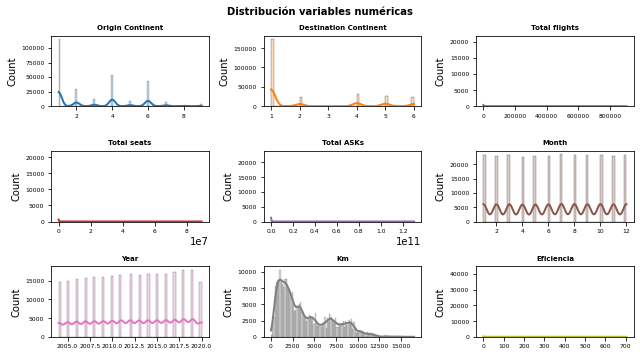

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = df_train.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('Destination Country')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df_train,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

#### 1.1. Datos numéricos
Primero comprobaremos si el conjunto de datos se presentan una distribución normal y, por lo tanto, podemos aplicar la estandarización en los datos.

In [20]:
df_train.columns

Index(['Origin Country', 'Origin Continent', 'Destination Country',
       'Destination Continent', 'Total flights', 'Total seats', 'Total ASKs',
       'Month', 'Year', 'Km', 'Eficiencia'],
      dtype='object')

In [21]:
numeric_features = ['Total flights','Total seats','Total ASKs', 'Km', 'Eficiencia']
numeric_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('robust', RobustScaler())
    ]
)

numeric_features_minmax = ['Year', 'Origin Continent', 'Destination Continent']
numeric_transformer_minmax = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'median')),
        ('minmax', MinMaxScaler())
    ]
)

#### 1.2. Datos categóricos

In [22]:
categorical_features = ['Origin Country']
categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'most_frequent', fill_value = 'missing')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

#### 1.3. Otros datos

In [23]:
origin_countries = df_train['Origin Country'].sort_values(ascending=True).unique()

In [24]:
country = {country: i+1 for i, country in enumerate(origin_countries)}

In [25]:
#df_train['Origin Country'] = df_train['Origin Country'].map(country)
#df_test['Origin Country'] = df_test['Origin Country'].map(country)

#### 1.3 Pipeline

In [26]:
preprocessor = ColumnTransformer(
    [
        #('Origin Country', CustomTransformer(),'Origin Country'),
        ('categoricals', categorical_transformer, categorical_features),
        ('numericals', numeric_transformer, numeric_features),
        ('numericals_minmax', numeric_transformer_minmax, numeric_features_minmax),
        
    ],
    remainder = 'drop'
)

### 2. Test/Train
Para poder cuantificar de forma correcta nuestro modelo, se necesita disponer de un conjunto de observaciones. Con esta finalidad, se dividirán los datos disponibles en un **conjunto de entrenamiento** y un **conjunto de validación**.

El tamaño adecuado de las particiones depende en gran medida de la cantidad de datos disponibles, en este caso, para agilizar el proceso dado el gran volumen de datos y para evitar el *overfiting*, se ha extraido aleatoria una sample representativa del conjunto de datos. 

In [27]:
data = df_train.sample(n=50000)

In [28]:
# Define the target variable and the features
X = data.drop(['Destination Country'], axis=1) #features
y = data['Destination Country'] #target

In [29]:
y.value_counts()

11    3305
15    2911
5     2889
2     2859
17    2854
8     2517
3     2517
7     2479
21    2317
13    2165
4     1840
18    1828
0     1786
14    1746
9     1719
24    1661
22    1641
10    1519
1     1509
19    1345
6     1343
20    1341
23    1306
12    1306
16    1297
Name: Destination Country, dtype: int64

In [30]:
# split into train test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(40000, 10) (10000, 10) (40000,) (10000,)


### 3. Modelo
Buscamos el mejor modelo

In [31]:
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(random_state = 42)
rfc = RandomForestClassifier(random_state = 42)
lr = LogisticRegression()

In [32]:
evaluation = pd.DataFrame({'model':['knc','dtc','rfc','lr']})

In [33]:
from sklearn.model_selection import cross_val_score

models = [knc, dtc, rfc, lr]
score_mean = []
score_std = []

for model in models:
    pipeline = Pipeline(
        [
            ('preprocessing', preprocessor),
            ('model', model)
        ]
    )
    score = cross_val_score(pipeline, X, y, cv=5, scoring='f1_macro')
    score_mean.append(score.mean())
    score_std.append(score.std())

In [34]:
evaluation['f1_cv'] = score_mean
evaluation['f1_std_cv'] = score_std
evaluation

,model,f1_cv,f1_std_cv
0,knc,0.783935,0.004188
1,dtc,0.916910,0.004782
2,rfc,0.912208,0.002732
3,lr,0.060734,0.004200


Seleccionamos los modelos dtc y rfc para su evaluación

### 4. Mejora parámetros en los modelos

#### 4.1.1. Mejora parámetros en modelos: Decission Tree Classifier

In [35]:
pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', DecisionTreeClassifier(random_state = 42))
    ]
)

params = { 
    'model__criterion':('gini', 'entropy'),
    'model__splitter': ('best','random'), 
    'model__max_depth': [None,10,100]
}

rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)

cv = GridSearchCV(pipeline, params, cv = rskf, scoring = ['f1_macro'], refit = 'f1_macro', n_jobs = -1)



cv.fit(X, y)

print(f'Best F1-score: {cv.best_score_:.3f}\n')
print(f'Best parameter set: {cv.best_params_}\n')
print(f'Scores: {classification_report(y, cv.predict(X))}')

Best F1-score: 0.929

Best parameter set: {'model__criterion': 'gini', 'model__max_depth': None, 'model__splitter': 'random'}

Scores:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1786
           1       1.00      1.00      1.00      1509
           2       1.00      1.00      1.00      2859
           3       1.00      1.00      1.00      2517
           4       1.00      1.00      1.00      1840
           5       1.00      1.00      1.00      2889
           6       1.00      1.00      1.00      1343
           7       1.00      1.00      1.00      2479
           8       1.00      1.00      1.00      2517
           9       1.00      1.00      1.00      1719
          10       1.00      1.00      1.00      1519
          11       1.00      1.00      1.00      3305
          12       1.00      1.00      1.00      1306
          13       1.00      1.00      1.00      2165
          14       1.00      1.00      1.00      1746


In [36]:
DecisionTreeClassifier()

pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=None, random_state=42))
    ]
)

score_dt_bp = cross_val_score(pipeline, X, y, cv=5, scoring='f1_macro')
print('F1 score: {0:.2f}'.format(score.mean()))

F1 score: 0.06


In [37]:
cv.cv_results_

{'mean_fit_time': array([2.08621392, 1.85885017, 0.92267401, 0.4839371 , 2.09296963,
        1.88495138, 2.77652013, 1.67862668, 1.74233544, 0.51283858,
        2.72180502, 1.68959191]),
 'std_fit_time': array([0.04805836, 0.05982343, 0.02317407, 0.02407844, 0.05217241,
        0.08431614, 0.02785499, 0.03083847, 0.0327258 , 0.0214668 ,
        0.01466581, 0.06471602]),
 'mean_score_time': array([0.03485239, 0.03620269, 0.03420246, 0.0362021 , 0.03700249,
        0.03750279, 0.03560317, 0.03430233, 0.03420303, 0.03190222,
        0.03300238, 0.03449223]),
 'std_score_time': array([0.00114075, 0.00483345, 0.00373651, 0.00538133, 0.00605053,
        0.00452232, 0.00349897, 0.00214677, 0.00487517, 0.00151403,
        0.00109563, 0.00342401]),
 'param_model__criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini',
                    'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                    'entropy'],
              mask=[False, False, False, False, F

#### 4.2.1. Mejora parámetros en modelos: Random Forest

In [38]:
pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', RandomForestClassifier(random_state = 42))
    ]
)

params = {
    'model__criterion':('gini', 'entropy'),
    'model__max_depth': [0.1,10,100]
}

rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)

cv = GridSearchCV(pipeline, params, cv = rskf, scoring = ['f1_macro'], refit = 'f1_macro', n_jobs = -1)



cv.fit(X, y)

print(f'Best F1-score: {cv.best_score_:.3f}\n')
print(f'Best parameter set: {cv.best_params_}\n')
print(f'Scores: {classification_report(y, cv.predict(X))}')

Best F1-score: 0.913

Best parameter set: {'model__criterion': 'gini', 'model__max_depth': 100}

Scores:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1786
           1       1.00      1.00      1.00      1509
           2       1.00      1.00      1.00      2859
           3       1.00      1.00      1.00      2517
           4       1.00      1.00      1.00      1840
           5       1.00      1.00      1.00      2889
           6       1.00      1.00      1.00      1343
           7       1.00      1.00      1.00      2479
           8       1.00      1.00      1.00      2517
           9       1.00      1.00      1.00      1719
          10       1.00      1.00      1.00      1519
          11       1.00      1.00      1.00      3305
          12       1.00      1.00      1.00      1306
          13       1.00      1.00      1.00      2165
          14       1.00      1.00      1.00      1746
          15       1.00      1

In [39]:
from sklearn.metrics import f1_score

pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', RandomForestClassifier(criterion = 'gini', 
                                         max_depth = 100, 
                                         random_state = 42))
    ]
)

score = cross_val_score(pipeline, X, y, cv=5, scoring='f1_macro')
print('F1 score: {0:.2f}'.format(score.mean()))

F1 score: 0.91


In [40]:
evaluation['f1_best.param'] = [0, 'Nan', 0.917 , 0]

In [41]:
evaluation

,model,f1_cv,f1_std_cv,f1_best.param
0,knc,0.783935,0.004188,0
1,dtc,0.916910,0.004782,Nan
2,rfc,0.912208,0.002732,0.917
3,lr,0.060734,0.004200,0


A pesar de los buenos resultados en un inicio del modelo DecisionTree, finalmente ha sido descartado por la variabilidad de resultado los mismos. Por lo tanto, se seleccionamos le modelo modelo **RandomForestClassifier**.

### 5. Predicción

In [42]:
# Train/Test division

# Define the target variable and the features
X_train = df_train.drop(['Destination Country'], axis=1) #features
y_train = df_train['Destination Country'] #target

X_test = df_test

In [43]:
#Create a model
rfc = RandomForestClassifier(criterion = 'gini', max_depth = 100, random_state = 42)

# Pipeline y ColumnTransformer
pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('model', rfc)
        ])

In [44]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categoricals',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Origin Country']),
                                                 ('numericals',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robust',
                       

In [45]:
#Prediction
y_pred = pipeline.predict(X_test)

In [46]:
df_predicciones = pd.DataFrame({'target': y_pred})

In [47]:
df_predicciones

,target
0,4
1,8
2,1
3,7
4,15
...,...
69241,13
69242,12
69243,3
69244,10


In [48]:
data = df_predicciones.to_dict()

In [49]:
with open("target.json", "w") as file:
    json.dump(data, file)